In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim

### Section 03 - LDA and Prior Seeding

#### 3.1 - Introduction

Section 03 and 04 contain the meat of our project: the topic modelling. Adam and I were keen on using a CVE dataset as a corpus because each document has an associated timestamp. We wanted to incorporate the the time structure somehow, and our first thought was to construct topic models and then analyse how the content of the corpus (i.e the derived topics) varied over time. Upon exploration of this aim we were underwhelmed- the topics generated were too 'fuzzy' to draw any incisive conclusions. Additionally, we thought that topic modelling was not needed to answer 'how does the corpus content vary over time?'. Indeed, investigating the time series of human selected key words (types of attack for instance) would probably produce similar, or better results. I eventually realised that we could incorporate the time structure in a different way: we could try to use our time structure to produce better topic models.

With the above context in mind, Sections 03 and 04 take the following structure:
* In 3.2 we derive a baseline topic model- an out of the box Latent Dirichlet Allocation (LDA).
* In 3.3 Bill investigates time based methods to derive 'important' words.
* In 3.4 Bill uses 'important' words to 'seed' the prior before running LDA.
* In 4 Adam investigates modelling each year individually, and sees if the granularity of this approach gives us any sense of how topics evolve in time.

Great! Let's get started.

#### 3.2 - Baseline Topic Model

We begin by retrieving the pre-processed data.

In [ ]:
from ast import literal_eval

df = pd.read_csv("../data/processed/formatted_df.csv").drop(columns = ['Unnamed: 0'])
df['Description'] = df['Description'].apply(literal_eval)
CVE_Corpus = df['Description']

We use a vanilla LDA as our baseline topic model, this is because our later efforts are all based on LDA and we want the results to be comparable to baseline. The LDA model from the `gensim` package is our choice. We first construct the set of all words, and a sparsely stored form of the corpus which we call `doc_word_matrix`. The first row of this matrix is printed to demonstrate the sparse storage.

In [18]:
vocab = gensim.corpora.Dictionary(CVE_Corpus)
doc_word_matrix = [vocab.doc2bow(doc) for doc in CVE_Corpus]
print(doc_word_matrix[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


We choose the number of topics and run LDA on the data. Adam and I toyed around with the idea of finding the optimal number of topics using cross-validation, but in the interest of time we decided to use 20 topics, as this was the number of topics used in [1] where Adam found the dataset. Such a bold choice shouldn't be too much of an issue since our analysis will be almost entirely qualitative and comparative.

In [19]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_word_matrix, id2word=vocab, num_topics=20)

Excellent. We visualise the generated topic model using the highly interactive `pyLDAvis` module. I saw this visulaisation tool used in a 2017 pyData talk [2] and wanted to give it a go myself!

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, doc_word_matrix, vocab)

/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.158503 -0.107258       1        1  10.717178
12    -0.159735  0.128993       2        1   9.097474
19    -0.109991 -0.032891       3        1   8.342347
18    -0.023605  0.094609       4        1   7.926150
4     -0.151235 -0.086655       5        1   7.505176
17    -0.148434  0.115261       6        1   6.569679
3     -0.146057 -0.006346       7        1   6.499134
8     -0.175217 -0.176747       8        1   6.134539
11    -0.070983  0.134063       9        1   5.073581
0     -0.065765  0.198699      10        1   4.693869
16    -0.000247 -0.204899      11        1   4.361118
2      0.086593 -0.246079      12        1   4.307986
5      0.125440  0.140788      13        1   3.218856
14     0.006027  0.064336      14        1   3.126051
9      0.168490  0.076874      15        1   2.622508
6      0.128329  0.063046      16        1   2.396646
10     0.101586 -0.174186      17        1   2.379206
15     0.102793  0.043665      18        1   2.210633
7      0.211049  0.009551      19        1   1.616825
13     0.279462 -0.034824      20        1   1.201044, topic_info=               Term           Freq          Total Category  logprob  loglift
797             cve   49979.000000   49979.000000  Default  30.0000  30.0000
132            code   63098.000000   63098.000000  Default  29.0000  29.0000
62    vulnerability  159118.000000  159118.000000  Default  28.0000  28.0000
192         version   90630.000000   90630.000000  Default  27.0000  27.0000
12          service   49939.000000   49939.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
1349       outdated      57.798607      59.087175  Topic20  -6.7668   4.3999
1288      detection     138.783384     390.770077  Topic20  -5.8908   3.3868
544           trust     283.665713    1951.947933  Topic20  -5.1759   2.4932
68             file     487.428724   52158.639965  Topic20  -4.6346  -0.2509
1126         remove     151.509432    1211.570802  Topic20  -5.8031   2.3430

[1010 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2225     12  0.999877      able
1702      8  0.993669  absolute
1185     15  0.998976     abuse
1493      2  0.998778        ac
14        2  0.095778    access
...     ...       ...       ...
128      15  0.996851         x
2573     17  0.984301     xerox
3609      5  0.999393       xml
1977     20  0.974772       xor
2251     10  0.998091       zip

[2123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 13, 20, 19, 5, 18, 4, 9, 12, 1, 17, 3, 6, 15, 10, 7, 11, 16, 8, 14])

The topics generated are interesting. Consider topic number 3 by moving your cursor over the bubble with that number. We see that this topic accounts for nearly all instances of 'buffer' and nearly all instances of 'overflow'- a good sign! However the very same topic accounts for nearly all instances of words like 'code', which one would guess should be more independent of topic.

During our background reading Adam and I saw that allignment between coherence measures and human perceptions is tenuous [3], and coherence may be inferior to other metrics to when trying to produce topic models which humans deem good [4]. Despite this we derive the UMass coherence for our topic model, mainly because it provides some quantative comparison with our subsequent models, and also we would have been struggling with time pressure if we wrote code for the measures suggested in [4]. 

In [22]:
from gensim.models.coherencemodel import CoherenceModel

c_model = CoherenceModel(model=lda_model, corpus=doc_word_matrix, coherence='u_mass')
coherence = c_model.get_coherence()
print(coherence)

-4.32104715047512


#### 3.3 - High Time For Time

Unusually, each document in our corpus belongs to a year, and we hope to incorporate this information into our topic modelling. Consider the set of frequent (topic worthy) words. For each word we can find the relative frequency of the documents which include the term in a given year. For terms like 'vulnerability' we expect this relative frequency to be somewhat time homogeneous. And for terms like 'sql' we expect the relative frequency to be nonhomogeneous. Lastly, given a topic, we should expect that it shouldn't account for all instances of a homogeneous word, and also all instances of an inhomogeneous word. It's precisely this idea which fuels our hypotheses:

**Hypothesis 1:** The less time homogeneous terms are more likely to be good 'topic titles'- that is, a human would suggest that such words should form the basis of some topic.

This hypothesis is all well and good but may not be very useful in practice. If our second hypothesis holds then the first hypothesis would be useful if true:

**Hypothesis 2:** By adjusting the weights of the prior topic-word distributions such that 'topic title' terms appear in distinct topics, with higher weights than the rest of the terms, we reach a more coherent topic model upon running LDA.

We call the reweighting of the prior topic-word distributions 'seeding'- we present the model with something we hope the algorithm can grow a more meaningful topic out of! LDA is a Bayesian inference problem, we optimise an impressively large parameter space to find a locally optimum solution, by adjusting the prior we arrive at a different local optimum, our second hypothesis states that we expect this second local optimum to be a better one. The analysis on whether these hypotheses hold is mostly qualitative, but we will also compare the UMass coherence score with the baseline model.

To be a good 'topic title' we would like the term to appear in a large number of documemnts which include the corresponding topic. We therefore start our analysis by finding a list of words which appear in a large number of documents. This is nice and easy as the `gensim.corpora.Dictionary` class automatically generates a `dfs` (document frequencies) dictionary for each word.

In [23]:
frequent_words = []
for i in range(0, len(vocab)):
    if vocab.dfs[i] > 5000:
        frequent_words.append(vocab[i])

len(frequent_words)

114

We see there are 114 terms appearing at least 5000 times, I would hope that a few meaningful 'topic titles' are included in this list. We now want to rank the terms by time homogeneity, and as is only natural, I pinch Adam's code for finding the indices of `df` which correspond to changes in the year.

In [24]:
names = df['Name']
year = []
for instance in names:
    year.append(int(instance[4:8]))
year_count = [0]
for i in range(23):
    if i == 0:
        year_count.append(year.count(i+1999))
    else:
        year_count.append(year.count(i+1999) + year_count[i]) 
print(year_count)

[0, 1541, 2778, 4313, 6663, 8161, 10794, 15380, 22238, 28579, 35550, 40437, 45429, 50016, 55417, 61539, 69818, 77734, 86935, 101254, 116737, 132011, 149827, 167676]


We now want to find the number of documents each of our `frequent_terms` is in for every year. We put this information into a dictionary where the keys are the words, and the values are a lists of the document frequencies for each year.

In [25]:
word_by_year = dict()

for word in frequent_words:
    word_signal = []
    for i in range(0, len(CVE_Corpus)):
        if word in CVE_Corpus[i]:
            word_signal.append(1)
        else:
            word_signal.append(0)

    x = []
    for i in range(0, len(year_count)-1):
        x.append(sum(word_signal[year_count[i]:year_count[i+1]]))
    
    word_by_year[word] = x

We note that each year has a different number of CVE entries, and the time homogeneity condition must respect this. Our null hypothesis is that our word is time homogenous: the document frequency of a word in a given year is proportional to the nummber of documents in that year. Stated another way the number of documents in each year gives us a categorical distribution, and the document frequency of a word gives us a distribution to test. This is a job for the chi-squared test statisitic. Lets first derive the categorical distribution using `year_count`

In [26]:
cat_distribution = []

for i in range(0, len(year_count)-1):
    cat_distribution.append((year_count[i+1] - year_count[i])/year_count[-1])

print(cat_distribution)
len(cat_distribution)

[0.009190343281089721, 0.007377322932321859, 0.00915455998473246, 0.014015124406593669, 0.008933896323862687, 0.01570290321811112, 0.027350366182399388, 0.04090030773634867, 0.03781698036689807, 0.04157422648441041, 0.02914549488298862, 0.02977170256924068, 0.0273563300651256, 0.0322109306042606, 0.03651089004985806, 0.049374985090293186, 0.04721009566067893, 0.054873684963858874, 0.08539683675660202, 0.09233879624991054, 0.09109234476013264, 0.10625253465015864, 0.10644934278012357]


23

Unfotunately, upon carrying this out I saw the every word had negligible p-value. See below for a snapshot of the code from this:

In [27]:
from scipy.stats import chisquare

chisquare(word_by_year['allow'], 
        f_exp= [i * (sum(word_by_year['allow'])) for i in cat_distribution])

Power_divergenceResult(statistic=9066.55697869281, pvalue=0.0)

Because the above process is totally indistinguishing, we instead consider the KL divergence between d the values of `word_by_year` considered as a distribution and `cat_distribution`. To quickly illustrate this:

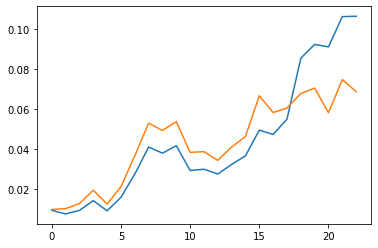

In [28]:
distribution = [i / (sum(word_by_year['allow'])) for i in word_by_year['allow']]

plt.plot(cat_distribution)
plt.plot(distribution)

We now calculate the KL divergence for each word.

In [29]:
def KL_div(a,b):
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    return sum(np.where(a != 0, a * np.log(a / b), 0))

In [30]:
KL_scores = dict()
for word in frequent_words:
    distribution = [year / (sum(word_by_year[word])) for year in word_by_year[word]]

    KL_scores[word] = KL_div(distribution,cat_distribution)

/var/folders/c6/5l1fxqh95lzdkbcb9p480sf00000gn/T/ipykernel_849/1047873131.py:4: RuntimeWarning: divide by zero encountered in log
  return sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/c6/5l1fxqh95lzdkbcb9p480sf00000gn/T/ipykernel_849/1047873131.py:4: RuntimeWarning: invalid value encountered in multiply
  return sum(np.where(a != 0, a * np.log(a / b), 0))


We then order the words by KL score.

In [32]:
KL_sorting = sorted(KL_scores, key=KL_scores.get, reverse=True)
KL_sorting

['successful',
 'unknown',
 'prior',
 'android',
 'unauthenticated',
 'vulnerable',
 'unspecified',
 'discover',
 'exploit',
 'result',
 'php',
 'lead',
 'execution',
 'validation',
 'exist',
 'different',
 'malicious',
 'disclosure',
 'v',
 'version',
 'note',
 'relate',
 'possibly',
 'sql',
 'affect',
 'input',
 'parameter',
 'issue',
 'vector',
 'multiple',
 'allows',
 'inject',
 'obtain',
 'product',
 'html',
 'aka',
 'properly',
 'corruption',
 'device',
 'url',
 'network',
 'plugin',
 'x',
 'injection',
 'send',
 'craft',
 'remote',
 'check',
 'sensitive',
 'command',
 'gain',
 'xss',
 'arbitrary',
 'software',
 'crosssite',
 'execute',
 'cve',
 'handle',
 'linux',
 'oracle',
 'contain',
 'application',
 'data',
 'management',
 'earlier',
 'process',
 'windows',
 'directory',
 'privilege',
 'component',
 'ibm',
 'id',
 'web',
 'impact',
 'denial',
 'microsoft',
 'kernel',
 'message',
 'memory',
 'cisco',
 'overflow',
 'crash',
 'access',
 'page',
 'script',
 'buffer',
 'authentic

Examining `KL_sorting` is quite bleak. It does not appear to me that the terms which would make good topic titles have found themselves further up the list, and also many terms which would make poor topic titles seem to be high up the list.

Even if we can find a good process for getting topic titles (this may or may not involve the time srtucture) we will probably end up with more topic titles than topics. We therefore want to consider a way to group titles into similar topics. We considered an algorithm which found the minimum Jaccard distance between all pairs of words and then groups this pair of words, and continue in the same manner until we reach the desired number of topics. We didn't end up writing code for this, but realised anyway that it suffered from a major flaw- words which could be in the same topic have extreme Jaccard distances, not necessarily small. To illustrate, 'buffer' and 'overflow' have a small Jaccard distance, but 'linux' and 'macos' (which could reasonably be in the same topic) have a large Jaccard distance. 

#### 3.4 - Careful Gardening

Even though the work in 3.3 was the opposite of a compelling success, we proceed unphased. There may be good methods for extracting 'topic titles' from a corpus, and the seeding idea therefore still warrants investigation.

Using our 'expert knowledge'(!) we've come up with a set of 'topic titles' from the `frequent_words` which we reckon are reasonable. These are presented below.

In [33]:
seed_0 = ['buffer', 'overflow']
seed_1 = ['xss', 'crosssite']
seed_2 = ['sql', 'injection']
seed_3 = ['plugin']
seed_4 = ['cisco', 'ibm', 'oracle']     # (Companies who find lots of vulnerabilities)

We now get right into the heart of `gensim`'s LDA model and alter the document word priors in accordance with the 'topic titles'. We go straight to the documentaition page and see the following optional input to the LDA model:

<img src='pic.png'></img>

We note that we need a matrix who's number of rows is the number of topics and columns are the number of words. We also spot (last line of picture) that there is auto prior finding functionality, I didn't know this was an option, and am a bit disappointed that I've been saying 'seeding' so much when this looks like fairly standard procedure! We'll give the auto-seeding a go to see if it does a better job than our own crafted prior. But first we'll make the matrix for our own prior.

In [34]:
def makerow(seed):
    constant = (1 - (0.1 * len(seed))) / (len(vocab) - len(seed))
    row = np.empty(len(vocab))
    row.fill(constant)
    for word in seed:
        row[vocab.token2id[word]] = 0.1
    return row

In [35]:
seeds = dict()
for row in range(0,20):
    seeds[row] = makerow([])
seeds[0] = makerow(seed_0)
seeds[1] = makerow(seed_1)
seeds[2] = makerow(seed_2)
seeds[3] = makerow(seed_3)
seeds[4] = makerow(seed_4)

And as a quick sanity check:

In [39]:
topic_word_prior = []
for row in range(0, 20):
    topic_word_prior.append(seeds[row])

In [40]:
print(topic_word_prior[0][vocab.token2id['buffer']])
print(topic_word_prior[0][vocab.token2id['buffer'] + 1])

0.1
5.0767219606300215e-06


Looks like we expected it to. We now run our LDA with the new prior, keeping the same number of topics to ensure comparability.

In [43]:
lda_model = LDA(corpus=doc_word_matrix, id2word=vocab, num_topics=20, eta=topic_word_prior)

/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/gensim/models/ldamodel.py:849: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, doc_word_matrix, vocab)

/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.035108 -0.022582       1        1  11.508851
13     0.121865 -0.160565       2        1   8.556011
18    -0.181951 -0.136863       3        1   8.037467
19    -0.217090 -0.119065       4        1   6.046469
10    -0.203531 -0.085293       5        1   5.836951
0      0.160777 -0.053961       6        1   5.573225
1      0.202333  0.145505       7        1   5.284599
2      0.030035  0.014945       8        1   5.009915
11    -0.126918 -0.167763       9        1   4.923902
3     -0.108163  0.080063      10        1   4.768852
16    -0.050986  0.152349      11        1   4.692242
8     -0.094950 -0.032273      12        1   4.590642
5     -0.024045  0.206578      13        1   4.018214
9      0.091926  0.033221      14        1   3.493137
7      0.069787  0.095737      15        1   3.263755
15    -0.132229  0.096704      16        1   3.051347
14     0.202467 -0.174824      17        1   3.023310
17     0.179524  0.122883      18        1   2.953450
6     -0.080833  0.209228      19        1   2.857182
4      0.197089 -0.204023      20        1   2.510478, topic_info=               Term           Freq          Total Category  logprob  loglift
797             cve   50254.000000   50254.000000  Default  30.0000  30.0000
132            code   54352.000000   54352.000000  Default  29.0000  29.0000
68             file   62165.000000   62165.000000  Default  28.0000  28.0000
192         version   74865.000000   74865.000000  Default  27.0000  27.0000
62    vulnerability  183915.000000  183915.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
68             file    4760.252350   62165.051368  Topic20  -3.0930   1.1152
1228           time    1309.095429    2530.818961  Topic20  -4.3839   3.0255
422        security    1820.059054   12727.966449  Topic20  -4.0544   1.7398
0             allow    2824.613637  108158.419131  Topic20  -3.6149   0.0395
77            local    1664.221224   15885.825850  Topic20  -4.1439   1.4286

[1197 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2225      2  1.000028      able
2350      2  0.998442     abort
1702      9  1.000303  absolute
1185      5  1.000100     abuse
1493      6  1.000452        ac
...     ...       ...       ...
3164      1  1.002499         z
560       1  0.002236      zero
560       7  0.999582      zero
2251      2  0.999418       zip
3165      1  1.000540      zope

[2246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 14, 19, 20, 11, 1, 2, 3, 12, 4, 17, 9, 6, 10, 8, 16, 15, 18, 7, 5])

We didn't anticipate the outcome of this- the seeded topics didn't even keep the seed words. Observe topic 1 which we seeded with 'buffer' and 'overflow', it no longer has anything to do with buffer overflows. This is a resounding failure, but let's calculate and compare the UMass score anyway.

In [46]:
c_model = CoherenceModel(model=lda_model, corpus=doc_word_matrix, coherence='u_mass')
coherence = c_model.get_coherence()
print(coherence)

-3.905856424702633


I ran the baseline and seeded version of our LDA multiple times and this is totally comparable coherence to our baseline model- we've made no improvements with our seeding.

Finally let's see if the auto-seeding does better. We not that it probably doesn't employ the time structure of the corpus given not all corpera have a meaningful time structure. If the auto-seeding does work it will be a slight confirmation that the idea wasn't total madness!

In [49]:
lda_model = LDA(corpus=doc_word_matrix, id2word=vocab, num_topics=50, eta='auto')
c_model = CoherenceModel(model=lda_model, corpus=doc_word_matrix, coherence='u_mass')
coherence = c_model.get_coherence()
print(coherence)

-6.856118484283903


We see the auto seeding has significantly worsened the coherence of the topics

#### 3.5 - Sources

* [1] M. A. Williams, S. Dey, R. C. Barranco, S. M. Naim, M. S. Hossain, M. Akbar, "Analyzing Evolving Trends of Vulnerabilities in National Vulnerability Database," 2018 IEEE International Conference on Big Data (Big Data), 2018, pp. 3011-3020, doi: 10.1109/BigData.2018.8622299. 
* [2] https://www.youtube.com/watch?v=UkmIljRIG_M
* [3] F. Rosner, A. Hinneburg, M. Röder, M. Nettling, A. Both, "Evaluating topic coherence measures," 2013
* [4] J. Chang,  & J. Boyd-Graber, S. Gerrish, C. Wang & D. Blei, "Reading Tea Leaves: How Humans Interpret Topic Models." Neural Information Processing Systems. 32. 288-296, 2009